# Presas en Nuevo León

(EDIT DESCRIPTION)

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: (CSV) Average ndvi and ndmi min, median, mean, max data by marginalization group.

Analysis 2: (MAP, BOXPLOT) Zones that may recieve irrigation within urban spaces and its relation with marginalization. Places without vegetation are discarted.(ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds).

Analysis 3: (CSV) From analisis 2, ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min) are located, ploted and exported to csv.

## Import libraries

In [153]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [2]:
#Save csvs to output>____?
csv_dataset = False 

#Save figures to output>____?
save_plots = False

## Data download

Data download

In [16]:
nuevoleon_originalsubset = gpd.read_file("../../../data/external/temporal_todocker/NuevoLeonSubset_original.csv")

## Data treatment

### Data treatment - Filter for usefull data

In [17]:
columns_tokeep = ['fechamonitoreo','clavesih','uso','elevcorona','bordolibre','nameelev','namealmac','namoelev','namoalmac','elevacionactual','almacenaactual','llenano','latitud','longitud']
nuevoleon_treatment = nuevoleon_originalsubset[columns_tokeep]

#Review result
print(nuevoleon_treatment.shape)
nuevoleon_treatment.head(2)

(18152, 14)


,fechamonitoreo,clavesih,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud
0,11/02/2021,PSANL,RI,0,0,232,19.01099968,232,19.01099968,229.57,8.574,0.451002059,27.429167,-100.372222
1,11/02/2021,LBCNL,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056


### Data treatment - Set names for reservoirs

In [18]:
nuevoleon_treatment['clavesih'].unique()

array(['PSANL', 'LBCNL', 'CCHNL', 'CPRNL', 'CCHNL          ',
       'CPRNL          ', 'LBCNL          ', 'PSANL          '],
      dtype=object)

In [19]:
def name_fromclave(clavesih):
    if (clavesih == 'PSANL' or clavesih == 'PSANL          '):
        return 'presa_salinillas'
    elif (clavesih == 'LBCNL' or clavesih == 'LBCNL          '):
        return 'presa_laboca'
    elif (clavesih == 'CPRNL' or clavesih == 'CPRNL          '):
        return 'presa_cerroprieto'
    elif (clavesih == 'CCHNL' or clavesih == 'CCHNL          '):
        return 'presa_elcuchillo'
    else:
          return "N/A"

nuevoleon_treatment['city'] = nuevoleon_treatment['clavesih'].apply(lambda x: name_fromclave(x))

#Review result
nuevoleon_treatment['city'].unique()

/tmp/ipykernel_2818/3275223676.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment['city'] = nuevoleon_treatment['clavesih'].apply(lambda x: name_fromclave(x))


array(['presa_salinillas', 'presa_laboca', 'presa_elcuchillo',
       'presa_cerroprieto'], dtype=object)

### Data treatment - Set datetime format

In [20]:
#Creates datetime data
nuevoleon_treatment['date'] = pd.to_datetime(nuevoleon_treatment['fechamonitoreo'],dayfirst=True)

#Review result
print(nuevoleon_treatment.shape)
nuevoleon_treatment.head(2)

(18152, 16)


/tmp/ipykernel_2818/1888229558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment['date'] = pd.to_datetime(nuevoleon_treatment['fechamonitoreo'],dayfirst=True)


,fechamonitoreo,clavesih,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud,city,date
0,11/02/2021,PSANL,RI,0,0,232,19.01099968,232,19.01099968,229.57,8.574,0.451002059,27.429167,-100.372222,presa_salinillas,2021-02-11
1,11/02/2021,LBCNL,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056,presa_laboca,2021-02-11


In [21]:
#Creates datetime data
nuevoleon_treatment['month'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%m')).astype('int64')
nuevoleon_treatment['year'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%y')).astype('int64')
nuevoleon_treatment['yearmonth'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%Y-%m'))

#Review result
print(nuevoleon_treatment.shape)
nuevoleon_treatment.head(2)

/tmp/ipykernel_2818/2937807798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment['month'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%m')).astype('int64')
/tmp/ipykernel_2818/2937807798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment['year'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%y')).astype('int64')
/tmp/ipykernel_2818/2937807798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


(18152, 19)


,fechamonitoreo,clavesih,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud,city,date,month,year,yearmonth
0,11/02/2021,PSANL,RI,0,0,232,19.01099968,232,19.01099968,229.57,8.574,0.451002059,27.429167,-100.372222,presa_salinillas,2021-02-11,2,21,2021-02
1,11/02/2021,LBCNL,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056,presa_laboca,2021-02-11,2,21,2021-02


### Data treatment - Cleaning

In [22]:
columns_tokeep = ['date','month','year','yearmonth','city','uso','elevcorona','bordolibre','nameelev','namealmac','namoelev','namoalmac','elevacionactual','almacenaactual','llenano','latitud','longitud']
presas_nuevoleon = nuevoleon_treatment[columns_tokeep]

#Review result
print(presas_nuevoleon.shape)
presas_nuevoleon.head(2)

(18152, 17)


,date,month,year,yearmonth,city,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud
0,2021-02-11,2,21,2021-02,presa_salinillas,RI,0,0,232,19.01099968,232,19.01099968,229.57,8.574,0.451002059,27.429167,-100.372222
1,2021-02-11,2,21,2021-02,presa_laboca,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056


### Data treatment - Explore data from La Boca (High namoalmac variation)

In [23]:
city = 'presa_laboca'

presa_gdf = presas_nuevoleon.loc[presas_nuevoleon.city==city]
presa_gdf.namoalmac.unique()

array(['39.49', '35.003', '35.83', '39.02', '35', '37.05', '36.65',
       '37.63', '38.1', '38.34', '37.78', '39.06', '38.29', '36.38',
       '37.49', '35.76', '37.37', '36.47', '37.21', '35.14', '37.83',
       '38.2', '37.06', '35.31', '36.51', '38.75', '38.49', '38.89',
       '38.63', '35.58', '35.45', '36.34', '39.2', '38.43', '35.42',
       '37.92', '37.97', '35.28', '38.06', '36.24', '35.55', '38.56',
       '39.16', '37.51', '36.16', '36.6', '36.91', '39.35', '36.1',
       '39.39', '37.23', '38.42', '37.64', '38.88', '35.69', '35.96',
       '39.34', '36.79', '35.09', '37.35', '35.89', '38.77', '36.78',
       '36.02'], dtype=object)

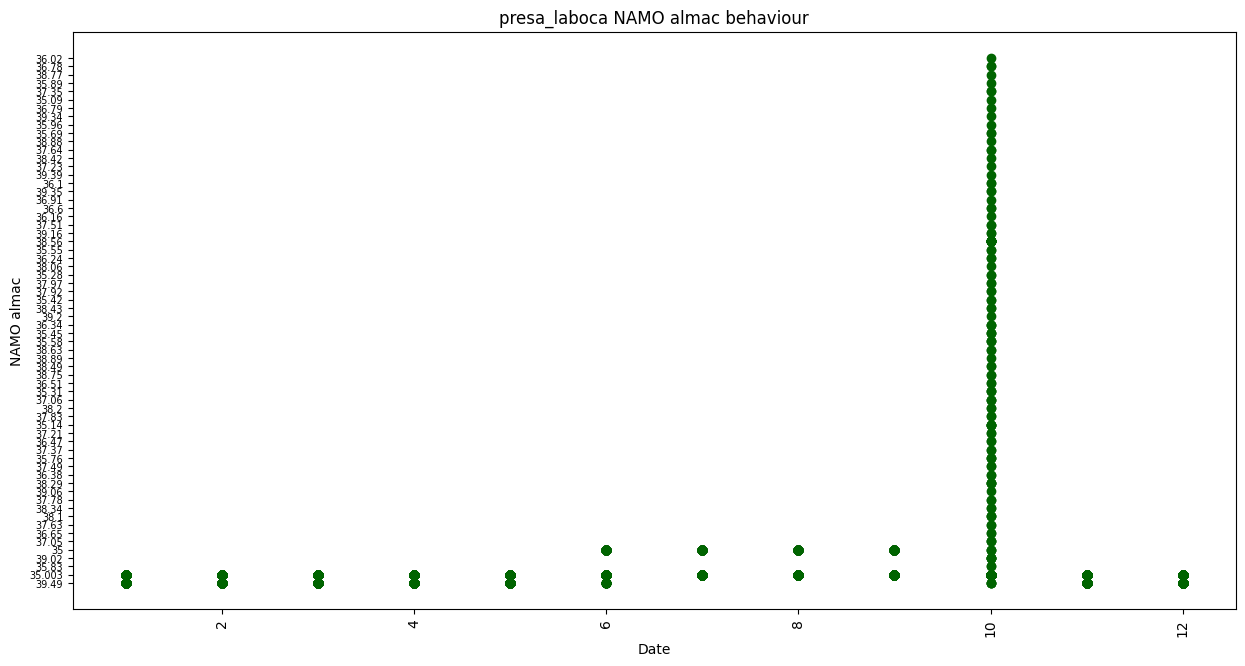

In [24]:
plt.figure(figsize=(15,7.5))
plt.scatter(presa_gdf['month'],presa_gdf['namoalmac'], color = 'darkgreen',linewidth = 1);

# ---------- Format ----------
# Format - Titles
plt.title('{} NAMO almac behaviour'.format(city))
plt.xlabel('Date')
plt.ylabel('NAMO almac')

# Format - x ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(10)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

In [108]:
historical_behaviour = pd.DataFrame()  

for city in presas_nuevoleon.city.unique():

    presa_gdf = presas_nuevoleon.loc[(presas_nuevoleon.city == city) &
                                   (presas_nuevoleon.year>= 16)&
                                   (presas_nuevoleon.year <= 22)]

    presa_gdf['almacenaactual'] = presa_gdf['almacenaactual'].astype('float')
    presa_gdf['elevacionactual'] = presa_gdf['elevacionactual'].astype('float')


    summary = presa_gdf.groupby('yearmonth').agg({'almacenaactual':np.mean,'elevacionactual':np.mean})
    summary['city'] = city
    summary = summary.reset_index()

    historical_behaviour = pd.concat([historical_behaviour,summary])
    

#Delete Salinillas
historical_behaviour = historical_behaviour.loc[(historical_behaviour.city == 'presa_laboca') |
                                                (historical_behaviour.city == 'presa_cerroprieto') |
                                                (historical_behaviour.city == 'presa_elcuchillo')]

#Show
historical_behaviour

/tmp/ipykernel_2818/484154855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presa_gdf['almacenaactual'] = presa_gdf['almacenaactual'].astype('float')
/tmp/ipykernel_2818/484154855.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presa_gdf['elevacionactual'] = presa_gdf['elevacionactual'].astype('float')
/tmp/ipykernel_2818/484154855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,yearmonth,almacenaactual,elevacionactual,city
0,2016-01,31.243933,446.688667,presa_laboca
1,2016-02,30.005346,446.396154,presa_laboca
2,2016-03,29.023321,446.164286,presa_laboca
3,2016-04,29.867704,446.363704,presa_laboca
4,2016-05,30.078074,446.413333,presa_laboca
...,...,...,...,...
79,2022-08,2.746240,258.247600,presa_cerroprieto
80,2022-09,36.943767,265.958667,presa_cerroprieto
81,2022-10,55.417320,268.928800,presa_cerroprieto
82,2022-11,57.774074,269.177407,presa_cerroprieto


## Data comparison

### Data comparison - Load and merge ndwi data

In [109]:
#Download
nldams_ndwi = gpd.read_file("../../../data/external/temporal_fromjupyter/nldams_ndwi.csv")

#Format
nldams_ndwi.drop(columns=['field_1','geometry'],inplace=True)

#Show
nldams_ndwi

,date,ndwi_mean,city
0,2016-01,0.5794266589959884,presa_laboca
1,2016-02,0.8281117497905571,presa_laboca
2,2016-03,0.7124677049494849,presa_laboca
3,2016-04,0.5968236604025097,presa_laboca
4,2016-05,0.4811796154302163,presa_laboca
...,...,...,...
247,2022-08,-0.06128631043334576,presa_elcuchillo
248,2022-09,-0.04022841582892871,presa_elcuchillo
249,2022-10,-0.019170481634708355,presa_elcuchillo
250,2022-11,0.0018874327524517607,presa_elcuchillo


In [139]:
summary = pd.DataFrame()  

for city in nldams_ndwi.city.unique():   
    nldams_ndwi_city = nldams_ndwi.loc[nldams_ndwi.city == city]
    historical_behaviour_city = historical_behaviour.loc[historical_behaviour.city == city]
    historical_behaviour_city = historical_behaviour_city.rename(columns={'yearmonth':'date'})
    historical_behaviour_city = historical_behaviour_city.drop(columns='city')

    temp = pd.merge(nldams_ndwi_city,historical_behaviour_city, on='date')
    summary = pd.concat([summary,temp])
    
summary

,date,ndwi_mean,city,almacenaactual,elevacionactual
0,2016-01,0.5794266589959884,presa_laboca,31.243933,446.688667
1,2016-02,0.8281117497905571,presa_laboca,30.005346,446.396154
2,2016-03,0.7124677049494849,presa_laboca,29.023321,446.164286
3,2016-04,0.5968236604025097,presa_laboca,29.867704,446.363704
4,2016-05,0.4811796154302163,presa_laboca,30.078074,446.413333
...,...,...,...,...,...
79,2022-08,-0.06128631043334576,presa_elcuchillo,446.397160,155.391200
80,2022-09,-0.04022841582892871,presa_elcuchillo,692.848300,158.365000
81,2022-10,-0.019170481634708355,presa_elcuchillo,762.970320,159.166400
82,2022-11,0.0018874327524517607,presa_elcuchillo,756.086556,159.096296


### Data comparison - Next steps

/tmp/ipykernel_2818/2928167187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laboca['ndwi_mean'] = laboca['ndwi_mean'].astype('float')


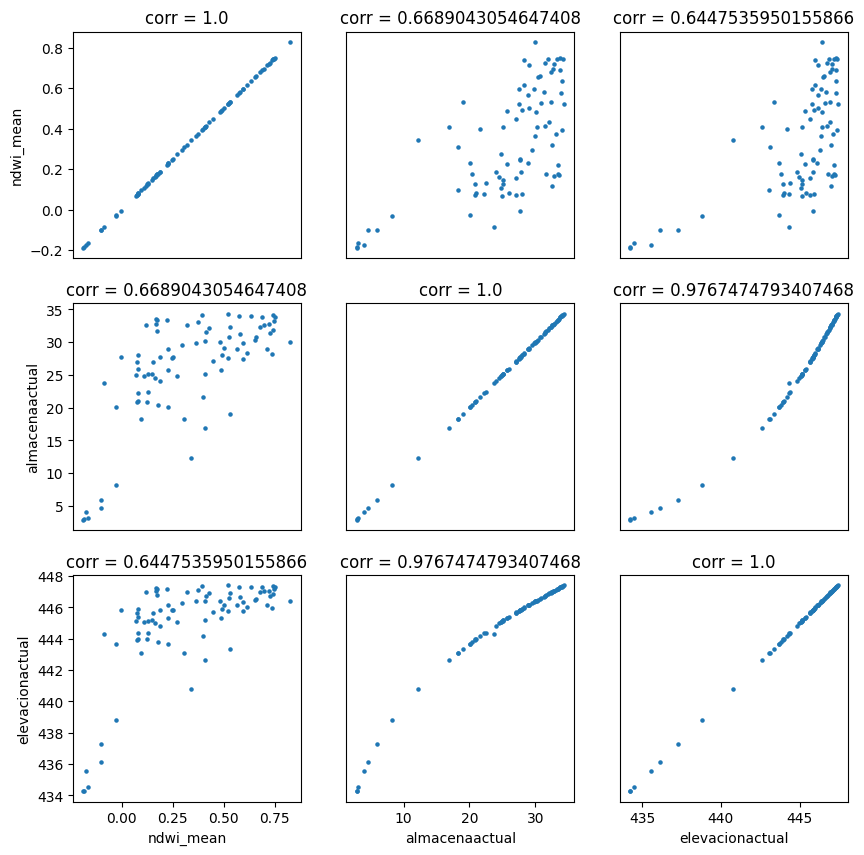

In [167]:
laboca = summary.loc[summary.city == 'presa_laboca']
laboca['ndwi_mean'] = laboca['ndwi_mean'].astype('float')

cols = ['ndwi_mean', 'almacenaactual', 'elevacionactual']

# Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))

# Iterar entre las columnas
for i in range(len(cols)):
    for j in range(len(cols)):
        #Plot
        axs[i,j].scatter(laboca[cols[j]], laboca[cols[i]], s=5)
        
        #Correlación
        corr, pval = stats.pearsonr(laboca[cols[j]],laboca[cols[i]])
        axs[i,j].set_title("corr = {}".format(corr))
        
        # Formato - apagar las tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Formato - prender las ticks de la última línea
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])

/tmp/ipykernel_2818/1020024877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laboca['ndwi_mean'] = laboca['ndwi_mean'].astype('float')


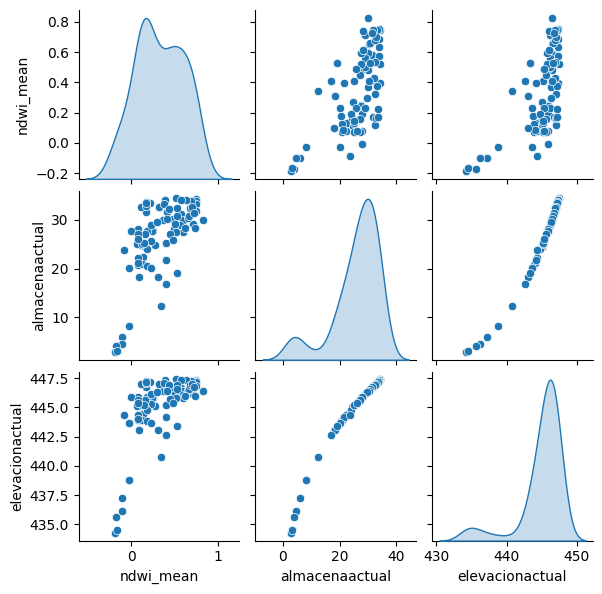

In [162]:
import seaborn as sns

laboca = summary.loc[summary.city == 'presa_laboca']
laboca['ndwi_mean'] = laboca['ndwi_mean'].astype('float')
prueba = laboca[['ndwi_mean', 'almacenaactual', 'elevacionactual']]

sns.pairplot(prueba, diag_kind='kde', height=2);